In [24]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, Input, Model
import h5py
import pickle
np.random.seed(42)
tf.random.set_seed(42)
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
earthquake_keys = np.load("../preprocessed/earthquake_keys.npy", allow_pickle=True)
noise_keys = np.load("../preprocessed/noise_keys.npy", allow_pickle=True)

with open("../preprocessed/key_to_label.pkl", "rb") as f:
    key_to_label = pickle.load(f)

with open("../preprocessed/station_to_keys.pkl", "rb") as f:
    station_to_keys = pickle.load(f)


train_samples = np.load("../preprocessed/train_split.npy", allow_pickle=True)
val_samples   = np.load("../preprocessed/val_split.npy", allow_pickle=True)
test_samples  = np.load("../preprocessed/test_split.npy", allow_pickle=True)

X_train = np.load("../preprocessed/spectrograms/X_train.npy")
y_train = np.load("../preprocessed/spectrograms/y_train.npy")
X_val = np.load("../preprocessed/spectrograms/X_val.npy")
y_val = np.load("../preprocessed/spectrograms/y_val.npy")
X_test = np.load("../preprocessed/spectrograms/X_test.npy")
y_test = np.load("../preprocessed/spectrograms/y_test.npy")

In [ ]:
file_path = "../data/merge.hdf5"

def get_arrivals_for_keys(h5_file, keys):
    p_arr, s_arr, p_exists, s_exists = [], [], [], []
    for k in keys:
        sample = h5_file['data'][k]
        trace_cat = sample.attrs["trace_category"].decode() if isinstance(sample.attrs["trace_category"], bytes) else sample.attrs["trace_category"]

        if trace_cat == "earthquake_local":
            p = sample.attrs.get("p_arrival_sample", np.nan)
            s = sample.attrs.get("s_arrival_sample", np.nan)
            p_arr.append(p)
            s_arr.append(s)
            p_exists.append(1)
            s_exists.append(1)
        else:
            p_arr.append(np.nan)
            s_arr.append(np.nan)
            p_exists.append(0)
            s_exists.append(0)
    return np.array(p_arr), np.array(s_arr), np.array(p_exists), np.array(s_exists)

with h5py.File(file_path, "r") as f:
    keys_train = train_samples[:, 0]
    p_train, s_train, p_exist_train, s_exist_train = get_arrivals_for_keys(f, keys_train)

    keys_val = val_samples[:, 0]
    p_val, s_val, p_exist_val, s_exist_val = get_arrivals_for_keys(f, keys_val)

    keys_test = test_samples[:, 0]
    p_test, s_test, p_exist_test, s_exist_test = get_arrivals_for_keys(f, keys_test)


In [ ]:
n_samples = 6000.0

def normalize_arrivals(arr):
  arr = np.array(arr, dtype=float)
  arr_norm = arr / n_samples
  arr_norm[np.isnan(arr_norm)] = -1.0   # mark missing with −1
  return arr_norm

p_train_norm = normalize_arrivals(p_train)
s_train_norm = normalize_arrivals(s_train)
p_val_norm   = normalize_arrivals(p_val)
s_val_norm   = normalize_arrivals(s_val)
p_test_norm  = normalize_arrivals(p_test)
s_test_norm  = normalize_arrivals(s_test)

In [ ]:
np.save("../preprocessed/p_arr_train.npy", p_train_norm)
np.save("../preprocessed/s_arr_train.npy", s_train_norm)
np.save("../preprocessed/p_exist_train.npy", p_exist_train)
np.save("../preprocessed/s_exist_train.npy", s_exist_train)

np.save("../preprocessed/p_arr_val.npy", p_val_norm)
np.save("../preprocessed/s_arr_val.npy", s_val_norm)
np.save("../preprocessed/p_exist_val.npy", p_exist_val)
np.save("../preprocessed/s_exist_val.npy", s_exist_val)

np.save("../preprocessed/p_arr_test.npy", p_test_norm)
np.save("../preprocessed/s_arr_test.npy", s_test_norm)
np.save("../preprocessed/p_exist_test.npy", p_exist_test)
np.save("../preprocessed/s_exist_test.npy", s_exist_test)

###### I had to denormalize because i made a mistake where i put -1 in the place of Nan values which is causing some problem while training and also it is not feasible in real-time prediction.

In [ ]:
n_samples = 6000.0

def denormalize_arrivals(arr_norm):
  arr = np.array(arr_norm,dtype=float)
  arr[arr < 0] = np.nan
  arr = arr * n_samples
  return arr

p_train_raw = denormalize_arrivals(p_arr_train)
s_train_raw = denormalize_arrivals(s_arr_train)
p_val_raw   = denormalize_arrivals(p_arr_val)
s_val_raw   = denormalize_arrivals(s_arr_val)
p_test_raw  = denormalize_arrivals(p_arr_test)
s_test_raw  = denormalize_arrivals(s_arr_test)

In [ ]:
def normalize_arrivals(arr):
  arr = np.array(arr, dtype=float)
  arr_norm = arr / n_samples
  arr_norm[np.isnan(arr_norm)] = 0.0
  return arr_norm

In [ ]:
p_train_norm = normalize_arrivals(p_train_raw)
s_train_norm = normalize_arrivals(s_train_raw)
p_val_norm   = normalize_arrivals(p_val_raw)
s_val_norm   = normalize_arrivals(s_val_raw)
p_test_norm  = normalize_arrivals(p_test_raw)
s_test_norm  = normalize_arrivals(s_test_raw)

In [ ]:
np.save("../preprocessed/p_arr_train.npy", p_train_norm)
np.save("../preprocessed/s_arr_train.npy", s_train_norm)

np.save("../preprocessed/p_arr_val.npy", p_val_norm)
np.save("../preprocessed/s_arr_val.npy", s_val_norm)

np.save("../preprocessed/p_arr_test.npy", p_test_norm)
np.save("../preprocessed/s_arr_test.npy", s_test_norm)

In [3]:
p_arr_train = np.load("../preprocessed/p_arr_train.npy")
s_arr_train = np.load("../preprocessed/s_arr_train.npy")
p_exist_train = np.load("../preprocessed/p_exist_train.npy")
s_exist_train = np.load("../preprocessed/s_exist_train.npy")

p_arr_val = np.load("../preprocessed/p_arr_val.npy")
s_arr_val = np.load("../preprocessed/s_arr_val.npy")
p_exist_val = np.load("../preprocessed/p_exist_val.npy")
s_exist_val = np.load("../preprocessed/s_exist_val.npy")

p_arr_test = np.load("../preprocessed/p_arr_test.npy")
s_arr_test = np.load("../preprocessed/s_arr_test.npy")
p_exist_test = np.load("../preprocessed/p_exist_test.npy")
s_exist_test = np.load("../preprocessed/s_exist_test.npy")

In [4]:
print(np.nanmin(p_arr_val), np.nanmax(p_arr_val))
print(np.mean(p_exist_val), np.mean(s_exist_val))

0.0 0.16666666666666666
0.2889487870619946 0.2889487870619946


In [5]:
y_train_multi = {
  "event_output": y_train,
  "p_output": p_arr_train,
  "s_output": s_arr_train
}

y_val_multi = {
  "event_output": y_val,
  "p_output": p_arr_val,
  "s_output": s_arr_val
}

y_test_multi = {
  "event_output": y_test,
  "p_output": p_arr_test,
  "s_output": s_arr_test
}

In [6]:
print(y_train_multi["event_output"][2]," ",y_train_multi["p_output"][2]," ",y_train_multi["s_output"][2])

1   0.13333333333333333   0.14408333333333334


In [12]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train_multi)).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val_multi)).batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test_multi)).batch(64).prefetch(tf.data.AUTOTUNE)

In [8]:
for x,y in train_ds.take(1):
  print(x[1])
  print('')
  print(np.array(y['event_output'])[0] , " " , np.array(y['p_output'])[0] , " " , np.array(y['s_output'])[0])

tf.Tensor(
[[[1.70094557e-02 3.27037415e-03 1.62849911e-02]
  [9.11938120e-03 1.69495065e-02 4.02877778e-02]
  [3.27586867e-02 1.63841788e-02 3.04350611e-02]
  ...
  [1.43728228e-02 2.80438680e-02 3.48051339e-02]
  [2.07381062e-02 2.16209330e-02 1.54060228e-02]
  [1.02544890e-03 2.38824841e-02 4.98010069e-02]]

 [[1.88368019e-02 1.22994715e-02 1.85452886e-02]
  [1.33287068e-02 3.59628312e-02 8.36557001e-02]
  [4.33120020e-02 2.53466424e-02 3.55706327e-02]
  ...
  [2.81318892e-02 9.55800936e-02 8.12972561e-02]
  [3.24454717e-02 6.56235665e-02 6.26738667e-02]
  [8.91376811e-04 2.96281576e-02 4.68786359e-02]]

 [[2.02672258e-02 2.20520869e-02 2.02590153e-02]
  [1.47200897e-02 4.27146778e-02 9.52569321e-02]
  [4.29038927e-02 1.63969416e-02 6.41857013e-02]
  ...
  [2.14223471e-02 1.19235978e-01 7.85094947e-02]
  [2.87227463e-02 5.59823997e-02 5.75716384e-02]
  [2.38749618e-03 3.81713212e-02 3.93313058e-02]]

 ...

 [[6.40378741e-04 9.09809780e-04 2.70097313e-04]
  [2.10569553e-08 2.32017943

#### Base-Line CNN Model

In [9]:
input_shape = X_train.shape[1:]

inp = Input(shape=input_shape)

x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(inp)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

shared = layers.Dense(128,activation='relu')(x)
shared = layers.Dropout(0.3)(shared)

event_output = layers.Dense(1,activation='sigmoid',name='event_output')(shared)

p_output = layers.Dense(1,activation='linear',name='p_output')(shared)

s_output = layers.Dense(1,activation='linear',name='s_output')(shared)

cnn_multi_model = Model(inputs=inp,outputs=[event_output,p_output,s_output])

cnn_multi_model.compile(
  optimizer = optimizers.Adam(1e-4),
  loss = {
    'event_output': 'binary_crossentropy',
    'p_output' : 'mse',
    's_output': 'mse'
  },
  metrics = {
    'event_output': 'accuracy',
    'p_output' :'mae',
    's_output' : 'mae'
  }
)

cnn_multi_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65, 95, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 65, 95, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 65, 95, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 47, 16)   0           ['batch_normalization[0][0]']

In [10]:
from tensorflow.keras import callbacks

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

In [ ]:
history_cnn = cnn_multi_model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[early_stop])

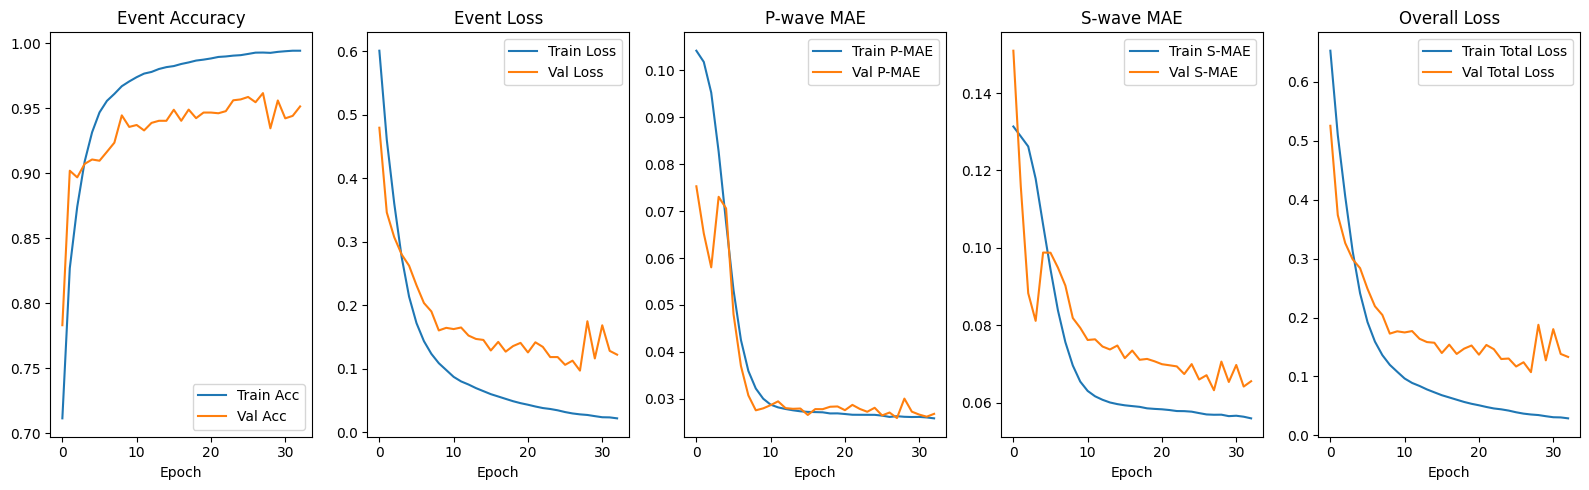

In [14]:
import matplotlib.pyplot as plt

history = history_cnn.history
epochs_ran = len(history['loss'])

plt.figure(figsize=(16,5))

# 1. Event classification accuracy
plt.subplot(1,5,1)
plt.plot(history['event_output_accuracy'], label='Train Acc')
plt.plot(history['val_event_output_accuracy'], label='Val Acc')
plt.title('Event Accuracy')
plt.xlabel('Epoch')
plt.legend()

# 2. Event classification loss
plt.subplot(1,5,2)
plt.plot(history['event_output_loss'], label='Train Loss')
plt.plot(history['val_event_output_loss'], label='Val Loss')
plt.title('Event Loss')
plt.xlabel('Epoch')
plt.legend()

# 3. P-wave MAE
plt.subplot(1,5,3)
plt.plot(history['p_output_mae'], label='Train P-MAE')
plt.plot(history['val_p_output_mae'], label='Val P-MAE')
plt.title('P-wave MAE')
plt.xlabel('Epoch')
plt.legend()

# 4. S-wave MAE
plt.subplot(1,5,4)
plt.plot(history['s_output_mae'], label='Train S-MAE')
plt.plot(history['val_s_output_mae'], label='Val S-MAE')
plt.title('S-wave MAE')
plt.xlabel('Epoch')
plt.legend()

# 5. Overall model loss
plt.subplot(1,5,5)
plt.plot(history['loss'], label='Train Total Loss')
plt.plot(history['val_loss'], label='Val Total Loss')
plt.title('Overall Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
(
  total_loss,
  event_output_loss,
  p_output_loss,
  s_output_loss,
  event_output_accuracy,
  p_output_mae,
  s_output_mae
) = cnn_multi_model.evaluate(test_ds)

print("Evaluation on test:")
print(f"Total Loss: {total_loss:.4f}")
print(f"Event Accuracy: {event_output_accuracy:.4f}")
print(f"P Loss: {p_output_loss:.4f} | P MAE: {p_output_mae:.4f}")
print(f"S Loss: {s_output_loss:.4f} | S MAE: {s_output_mae:.4f}")


115/115 [==============================] - 2s 13ms/step - loss: 0.1827 - event_output_loss: 0.1728 - p_output_loss: 0.0017 - s_output_loss: 0.0083 - event_output_accuracy: 0.9397 - p_output_mae: 0.0338 - s_output_mae: 0.0626
Evaluation on test:
Total Loss: 0.1827
Event Accuracy: 0.9397
P Loss: 0.0017 | P MAE: 0.0338
S Loss: 0.0083 | S MAE: 0.0626


In [17]:
cnn_multi_model.save("../models/cnn_baseline_multi_model")

INFO:tensorflow:Assets written to: ../models/cnn_baseline_multi_model\assets


INFO:tensorflow:Assets written to: ../models/cnn_baseline_multi_model\assets


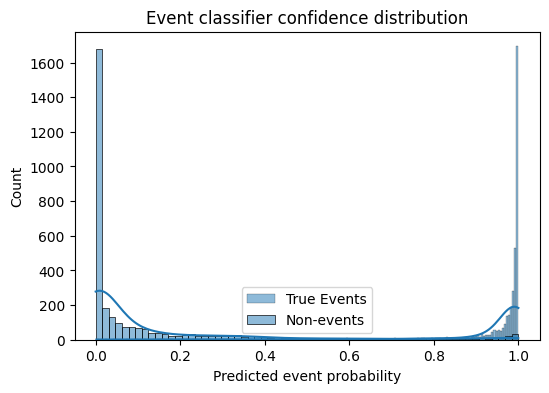

In [29]:
import seaborn as sns


event_preds = []
event_true = []

for x, y in test_ds:
  p = cnn_multi_model.predict(x, verbose=0)[0]
  event_preds.append(p)
  event_true.append(y["event_output"])

event_preds = np.concatenate(event_preds)
event_true = np.concatenate(event_true)

plt.figure(figsize=(6,4))
sns.histplot(event_preds[event_true==1], label='True Events', kde=True)
sns.histplot(event_preds[event_true==0], label='Non-events', kde=True)
plt.legend()
plt.xlabel("Predicted event probability")
plt.title("Event classifier confidence distribution")
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error

p_true_all,p_pred_all = [],[]
s_true_all,s_pred_all = [],[]

for x,y in test_ds:
  p_pred,s_pred = cnn_multi_model.predict(x,verbose=0)[1:]
  p_true_all.append(y["p_output"])
  s_true_all.append(y["s_output"])
  p_pred_all.append(p_pred)
  s_pred_all.append(s_pred)

p_true_all = np.concatenate(p_true_all)
s_true_all = np.concatenate(s_true_all)
p_pred_all = np.concatenate(p_pred_all)
s_pred_all = np.concatenate(s_pred_all)

n_samples = 6000
print("P MAE (samples):", mean_absolute_error(p_true_all, p_pred_all) * n_samples)
print("S MAE (samples):", mean_absolute_error(s_true_all, s_pred_all) * n_samples)

P MAE (samples): 202.63360719661472
S MAE (samples): 375.68210069498207


##### The model right now is also predicting the p_output and s_output for the noise traces which we don't want that's why we use masking.

In [8]:
def masked_mse(y_true, y_pred):
  mask = tf.cast(y_true > 1e-3, tf.float32)
  return tf.reduce_sum(mask * tf.square(y_true - y_pred)) / (tf.reduce_sum(mask) + 1e-8)

In [33]:
cnn_multi_model.compile(
  optimizer=optimizers.Adam(1e-4),
  loss={
    'event_output': 'binary_crossentropy',
    'p_output': masked_mse,
    's_output': masked_mse
  },
  metrics={
    'event_output': 'accuracy',
    'p_output': 'mae',
    's_output': 'mae'
  }
)

In [ ]:
history_cnn_masked = cnn_multi_model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[early_stop])

In [35]:
(
  total_loss,
  event_output_loss,
  p_output_loss,
  s_output_loss,
  event_output_accuracy,
  p_output_mae,
  s_output_mae
) = cnn_multi_model.evaluate(test_ds)

print("Evaluation on test:")
print(f"Total Loss: {total_loss:.4f}")
print(f"Event Accuracy: {event_output_accuracy:.4f}")
print(f"P Loss: {p_output_loss:.4f} | P MAE: {p_output_mae:.4f}")
print(f"S Loss: {s_output_loss:.4f} | S MAE: {s_output_mae:.4f}")

115/115 [==============================] - 1s 9ms/step - loss: 0.2364 - event_output_loss: 0.2250 - p_output_loss: 5.6010e-04 - s_output_loss: 0.0109 - event_output_accuracy: 0.9472 - p_output_mae: 0.0623 - s_output_mae: 0.2194
Evaluation on test:
Total Loss: 0.2364
Event Accuracy: 0.9472
P Loss: 0.0006 | P MAE: 0.0623
S Loss: 0.0109 | S MAE: 0.2194


In [36]:
cnn_multi_model.save("../models/cnn_baseline_multi_model_masking")

INFO:tensorflow:Assets written to: ../models/cnn_baseline_multi_model_masking\assets


INFO:tensorflow:Assets written to: ../models/cnn_baseline_multi_model_masking\assets


### CNN-LSTM Hybrid Model

In [14]:
from tensorflow.keras import layers, Model, Input
import tensorflow as tf

def build_cnn_lstm_model(input_shape=(65, 95, 3)):
  inputs = Input(shape=input_shape)

  x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2,2))(x)

  
  x = layers.Reshape((-1, x.shape[-1]))(x)

  x = layers.LSTM(128, return_sequences=False)(x)
  x = layers.Dropout(0.3)(x)

  event_output = layers.Dense(1, activation='sigmoid', name='event_output')(x)
  p_output = layers.Dense(1, activation='linear', name='p_output')(x)
  s_output = layers.Dense(1, activation='linear', name='s_output')(x)

  return Model(inputs, [event_output, p_output, s_output], name="cnn_lstm_model")

cnn_lstm_multi_model = build_cnn_lstm_model()
cnn_lstm_multi_model.summary()

Model: "cnn_lstm_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 65, 95, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 65, 95, 32)   896         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 32, 47, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 47, 64)   18496       ['max_pooling2d_2[0][0]']        
                                                                                     

In [15]:
cnn_lstm_multi_model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-4),
  loss={
    "event_output": "binary_crossentropy",
    "p_output": masked_mse,
    "s_output": masked_mse
  },
  metrics={
    "event_output": "accuracy",
    "p_output": "mae",
    "s_output": "mae"
  }
)

In [ ]:
history_cnn_lstm_multi_model = cnn_lstm_multi_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

In [17]:
(
  total_loss,
  event_output_loss,
  p_output_loss,
  s_output_loss,
  event_output_accuracy,
  p_output_mae,
  s_output_mae
) = cnn_lstm_multi_model.evaluate(test_ds)

print("Evaluation on test:")
print(f"Total Loss: {total_loss:.4f}")
print(f"Event Accuracy: {event_output_accuracy:.4f}")
print(f"P Loss: {p_output_loss:.4f} | P MAE: {p_output_mae:.4f}")
print(f"S Loss: {s_output_loss:.4f} | S MAE: {s_output_mae:.4f}")

115/115 [==============================] - 2s 13ms/step - loss: 0.0975 - event_output_loss: 0.0948 - p_output_loss: 3.9831e-04 - s_output_loss: 0.0023 - event_output_accuracy: 0.9840 - p_output_mae: 0.0555 - s_output_mae: 0.2358
Evaluation on test:
Total Loss: 0.0975
Event Accuracy: 0.9840
P Loss: 0.0004 | P MAE: 0.0555
S Loss: 0.0023 | S MAE: 0.2358


In [18]:
cnn_lstm_multi_model.save("../models/cnn_lstm_multi_model")

INFO:tensorflow:Assets written to: ../models/cnn_lstm_multi_model\assets


INFO:tensorflow:Assets written to: ../models/cnn_lstm_multi_model\assets


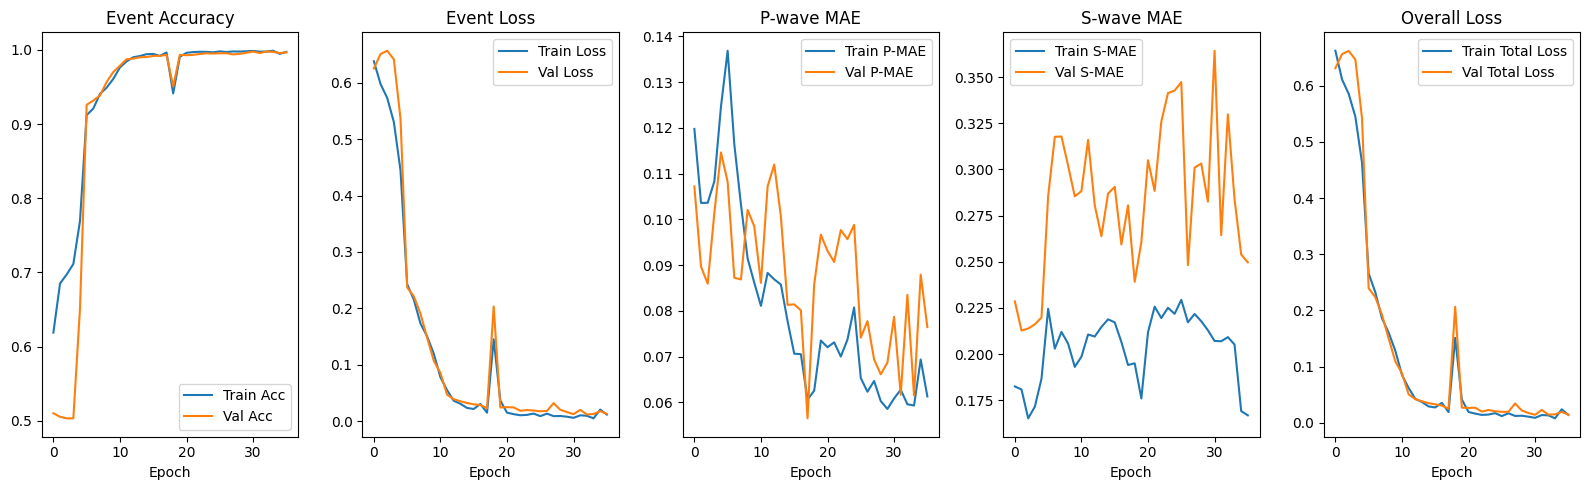

In [19]:
import matplotlib.pyplot as plt

history = history_cnn_lstm_multi_model.history
epochs_ran = len(history['loss'])

plt.figure(figsize=(16,5))

# 1. Event classification accuracy
plt.subplot(1,5,1)
plt.plot(history['event_output_accuracy'], label='Train Acc')
plt.plot(history['val_event_output_accuracy'], label='Val Acc')
plt.title('Event Accuracy')
plt.xlabel('Epoch')
plt.legend()

# 2. Event classification loss
plt.subplot(1,5,2)
plt.plot(history['event_output_loss'], label='Train Loss')
plt.plot(history['val_event_output_loss'], label='Val Loss')
plt.title('Event Loss')
plt.xlabel('Epoch')
plt.legend()

# 3. P-wave MAE
plt.subplot(1,5,3)
plt.plot(history['p_output_mae'], label='Train P-MAE')
plt.plot(history['val_p_output_mae'], label='Val P-MAE')
plt.title('P-wave MAE')
plt.xlabel('Epoch')
plt.legend()

# 4. S-wave MAE
plt.subplot(1,5,4)
plt.plot(history['s_output_mae'], label='Train S-MAE')
plt.plot(history['val_s_output_mae'], label='Val S-MAE')
plt.title('S-wave MAE')
plt.xlabel('Epoch')
plt.legend()

# 5. Overall model loss
plt.subplot(1,5,5)
plt.plot(history['loss'], label='Train Total Loss')
plt.plot(history['val_loss'], label='Val Total Loss')
plt.title('Overall Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

##### Testing with some values

In [19]:
def predict_event_ps(model,x,y_true=None,threshold=0.5):
  
  if len(x.shape) == 3:
    x = np.expand_dims(x,axis=0)
  
  preds = model.predict(x,verbose=0)

  if isinstance(preds,dict):
    event_pred = preds["event_output"]
    p_pred = preds["p_output"]
    s_pred = preds["s_output"]

  else:
    event_pred,p_pred,s_pred = preds
  
  event_val = float(event_pred[0][0])
  p_val = float(p_pred[0][0])
  s_val = float(s_pred[0][0])

  event_label = int(event_val > threshold)

  print("Predictions : ")
  print(f"Event Probability: {event_val:.4f} -> Detected: {bool(event_label)}")
  print(f"P Arrival Prediction: {p_val:.4f}")
  print(f"S Arrival Prediction: {s_val:.4f}")

  if y_true is not None:
    print("True Values:")
    print(f"Event: {y_true['event_output']}")
    print(f"P Arrival: {y_true['p_output']}")
    print(f"S Arrival: {y_true['s_output']}")


  return {
    "event_prob": event_val,
    "event_detected": bool(event_label),
    "p_pred": p_val,
    "s_pred": s_val
  } 

In [ ]:
idx = np.random.randint(len(X_test))

x_sample = X_test[idx]
y_sample = {
    "event_output": y_test_multi["event_output"][idx],
    "p_output": y_test_multi["p_output"][idx],
    "s_output": y_test_multi["s_output"][idx]
}

predict_event_ps(cnn_lstm_multi_model, x_sample, y_sample)

Predictions : 
Event Probability: 0.0001 -> Detected: False
P Arrival Prediction: 0.1134
S Arrival Prediction: 0.3362
True Values:
Event: 0
P Arrival: 0.0
S Arrival: 0.0


{'event_prob': 6.86516214045696e-05,
 'event_detected': False,
 'p_pred': 0.11340810358524323,
 's_pred': 0.3361738920211792}

##### In real-time we will ignore the p_output and s_output of the event whose event probability is less than the threshold value which is 0.5 , this is just considered as noise.

##### Model Evaluation of the Best Model (CNN-LSTM) Hybrid

In [9]:
from tensorflow.keras.models import load_model

cnn_lstm_multi_model = load_model("../models/cnn_lstm_multi_model",custom_objects={'masked_mse':masked_mse},compile=False)

In [10]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

event_preds, event_true = [], []
p_preds, p_true = [], []
s_preds, s_true = [], []

for x,y in test_ds:
  preds = cnn_lstm_multi_model.predict(x,verbose=0)
  event_preds.append(preds[0])
  p_preds.append(preds[1])
  s_preds.append(preds[2])
  
  event_true.append(y['event_output'])
  p_true.append(y['p_output'])
  s_true.append(y['s_output'])

event_preds = np.concatenate(event_preds).flatten()
event_true = np.concatenate(event_true).flatten()
p_preds = np.concatenate(p_preds).flatten()
p_true = np.concatenate(p_true).flatten()
s_preds = np.concatenate(s_preds).flatten()
s_true = np.concatenate(s_true).flatten()

In [22]:
threshold = 0.6
event_pred_labels = (event_preds > threshold).astype(int)

precision = precision_score(event_true, event_pred_labels)
recall = recall_score(event_true, event_pred_labels)
f1 = f1_score(event_true, event_pred_labels)
auc = roc_auc_score(event_true, event_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Precision: 0.9771
Recall: 0.9962
F1 Score: 0.9866
AUC: 0.9917


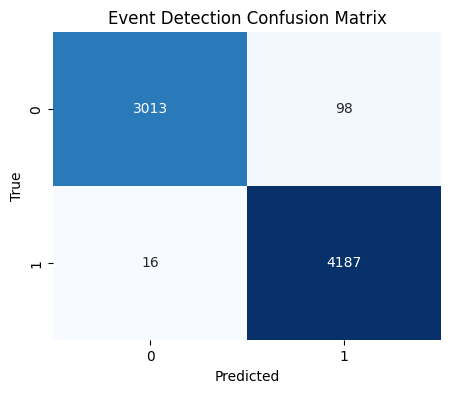

In [23]:
cm = confusion_matrix(event_true, event_pred_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Event Detection Confusion Matrix")
plt.show()

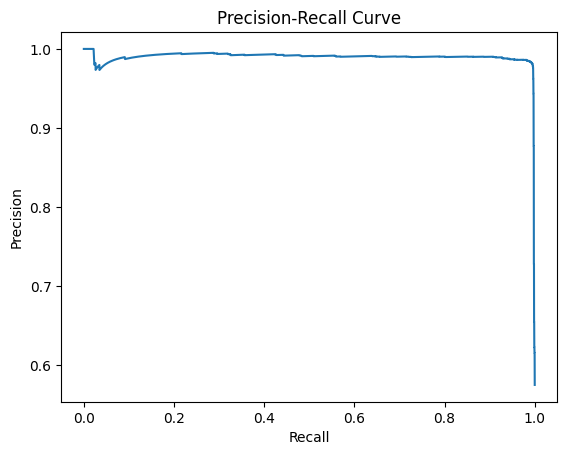

In [24]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(event_true,event_preds)
plt.plot(recalls,precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [26]:
from sklearn.metrics import root_mean_squared_error
p_mae = mean_absolute_error(p_true, p_preds)
s_mae = mean_absolute_error(s_true, s_preds)
p_rmse = root_mean_squared_error(p_true, p_preds)
s_rmse = root_mean_squared_error(s_true, s_preds)

print(f"P MAE: {p_mae:.4f}, RMSE: {p_rmse:.4f}")
print(f"S MAE: {s_mae:.4f}, RMSE: {s_rmse:.4f}")

P MAE: 0.0555, RMSE: 0.0704
S MAE: 0.2358, RMSE: 0.3457


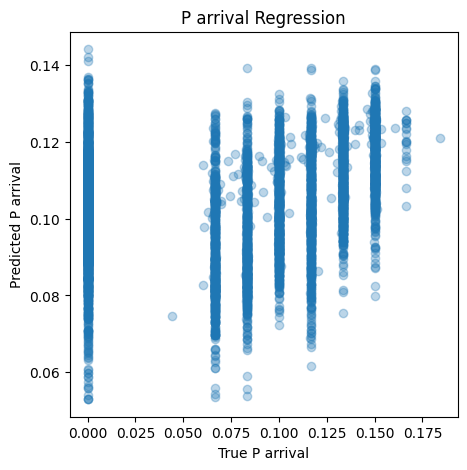

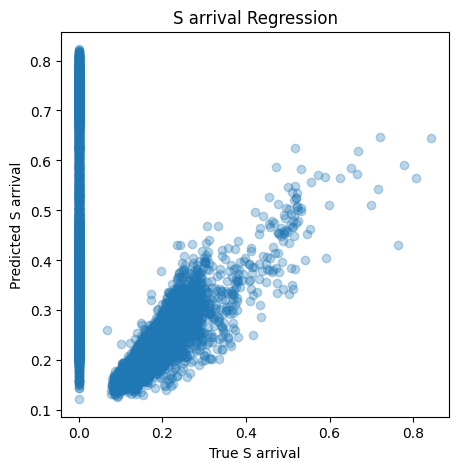

In [28]:
plt.figure(figsize=(5,5))
plt.scatter(p_true,p_preds,alpha=0.3)
plt.xlabel("True P arrival")
plt.ylabel("Predicted P arrival")
plt.title("P arrival Regression")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(s_true,s_preds,alpha=0.3)
plt.xlabel("True S arrival")
plt.ylabel("Predicted S arrival")
plt.title("S arrival Regression")
plt.show()

##### Grad-CAM

In [29]:
import numpy as np
sample = X_val[10:11]

In [31]:
for layer in cnn_lstm_multi_model.layers:
  if 'conv' in layer.name:
    print(layer.name)

conv2d_3
conv2d_4
conv2d_5


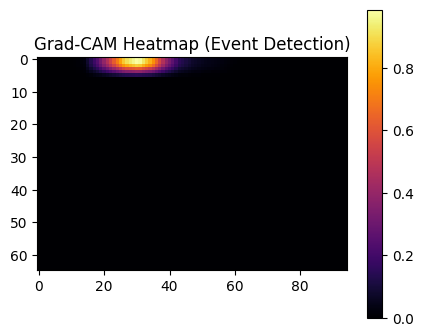

In [41]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def get_gradcam_heatmap(model, image, last_conv_layer_name, output_name="event_output"):
    
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.get_layer(output_name).output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (65, 95))
    return heatmap.numpy().squeeze()


last_conv_layer_name = "conv2d_5"
heatmap = get_gradcam_heatmap(cnn_lstm_multi_model, sample, last_conv_layer_name)

plt.figure(figsize=(5, 4))
plt.imshow(heatmap, cmap="inferno")
plt.title("Grad-CAM Heatmap (Event Detection)")
plt.colorbar()
plt.show()

### Model Update: Masked Loss for Earthquake Labels

In [7]:
print("X_train shape:", X_train.shape)
print("y_train['event_output'] shape:", y_train_multi['event_output'].shape)
print("y_train['p_output'] shape:", y_train_multi['p_output'].shape)
print("y_train['s_output'] shape:", y_train_multi['s_output'].shape)

X_train shape: (55266, 65, 95, 3)
y_train['event_output'] shape: (55266,)
y_train['p_output'] shape: (55266,)
y_train['s_output'] shape: (55266,)


In [8]:
print("Event labels unique:", np.unique(y_train_multi['event_output']))
print("P arrival min/max:", np.nanmin(y_train_multi['p_output']), np.nanmax(y_train_multi['p_output']))
print("S arrival min/max:", np.nanmin(y_train_multi['s_output']), np.nanmax(y_train_multi['s_output']))

Event labels unique: [0 1]
P arrival min/max: 0.0 0.37283333333333335
S arrival min/max: 0.0 0.878


In [9]:
import tensorflow as tf

def masked_mse(y_true, y_pred):
  event = y_true[:, 0]        # event labels
  arrival = y_true[:, 1]      # actual P or S value

  mask = tf.cast(event > 0, tf.float32)  # 1 if event happened, 0 if not
  sq_err = tf.square(arrival - y_pred[:, 0]) * mask

  return tf.reduce_sum(sq_err) / (tf.reduce_sum(mask) + 1e-6)

In [10]:
y_train_multi_masked = {
    'event_output': y_train_multi['event_output'],
    'p_output': np.stack([y_train_multi['event_output'], y_train_multi['p_output']], axis=1),
    's_output': np.stack([y_train_multi['event_output'], y_train_multi['s_output']], axis=1)
}

y_val_multi_masked = {
    'event_output': y_val_multi['event_output'],
    'p_output': np.stack([y_val_multi['event_output'], y_val_multi['p_output']], axis=1),
    's_output': np.stack([y_val_multi['event_output'], y_val_multi['s_output']], axis=1)
}

y_test_multi_masked = {
    'event_output': y_test_multi['event_output'],
    'p_output': np.stack([y_test_multi['event_output'], y_test_multi['p_output']], axis=1),
    's_output': np.stack([y_test_multi['event_output'], y_test_multi['s_output']], axis=1)
}

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_multi_masked)).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val_multi_masked)).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test_multi_masked)).batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
def build_cnn_lstm_model(input_shape=(65, 95, 3)):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Flatten for LSTM
    x = layers.Reshape((-1, x.shape[-1]))(x)

    # Stacked LSTM
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.LSTM(128, return_sequences=False)(x)
    x = layers.Dropout(0.3)(x)

    # Outputs
    event_output = layers.Dense(1, activation='sigmoid', name='event_output')(x)
    p_output = layers.Dense(1, activation='linear', name='p_output')(x)
    s_output = layers.Dense(1, activation='linear', name='s_output')(x)

    return Model(inputs, [event_output, p_output, s_output], name="cnn_lstm_model")

cnn_lstm_multi_model_fixedmask = build_cnn_lstm_model()
cnn_lstm_multi_model_fixedmask.summary()

Model: "cnn_lstm_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65, 95, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 65, 95, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 65, 95, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 47, 64)   0           ['batch_normalizatio

In [12]:
cnn_lstm_multi_model_fixedmask.compile(
  optimizer='adam',
  loss={
    'event_output': 'binary_crossentropy',
    'p_output': masked_mse,
    's_output': masked_mse
  },
  metrics={
    'event_output': 'accuracy',
    'p_output': 'mse',
    's_output': 'mse'
  }
)

In [13]:
from tensorflow.keras import callbacks

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

In [14]:
history_cnn_lstm_multi_model_fixedmask = cnn_lstm_multi_model_fixedmask.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
1728/1728 [==============================] - 70s 34ms/step - loss: 0.5518 - event_output_loss: 0.5137 - p_output_loss: 0.0179 - s_output_loss: 0.0202 - event_output_accuracy: 0.7342 - p_output_mse: 0.3422 - s_output_mse: 0.2924 - val_loss: 0.4519 - val_event_output_loss: 0.4398 - val_p_output_loss: 8.8513e-04 - val_s_output_loss: 0.0113 - val_event_output_accuracy: 0.7714 - val_p_output_mse: 0.1446 - val_s_output_mse: 0.2137
Epoch 2/50
1728/1728 [==============================] - 56s 33ms/step - loss: 0.2675 - event_output_loss: 0.2575 - p_output_loss: 0.0024 - s_output_loss: 0.0075 - event_output_accuracy: 0.9089 - p_output_mse: 0.2353 - s_output_mse: 0.2566 - val_loss: 0.1692 - val_event_output_loss: 0.1632 - val_p_output_loss: 3.7214e-04 - val_s_output_loss: 0.0056 - val_event_output_accuracy: 0.9414 - val_p_output_mse: 0.1261 - val_s_output_mse: 0.1743
Epoch 3/50
1728/1728 [==============================] - 59s 34ms/step - loss: 0.0547 - event_output_loss: 0.0466 - p_out

In [17]:
(
  total_loss,
  event_output_loss,
  p_output_loss,
  s_output_loss,
  event_output_accuracy,
  p_output_mse,
  s_output_mse
) = cnn_lstm_multi_model_fixedmask.evaluate(test_ds)

print("Evaluation on test:")
print(f"Total Loss: {total_loss:.4f}")
print(f"Event Accuracy: {event_output_accuracy:.4f}")
print(f"P Loss: {p_output_loss:.4f} | P MSE: {p_output_mse:.4f}")
print(f"S Loss: {s_output_loss:.4f} | S MSE: {s_output_mse:.4f}")

229/229 [==============================] - 3s 12ms/step - loss: 0.0250 - event_output_loss: 0.0182 - p_output_loss: 4.1246e-04 - s_output_loss: 0.0064 - event_output_accuracy: 0.9940 - p_output_mse: 0.2300 - s_output_mse: 0.3777
Evaluation on test:
Total Loss: 0.0250
Event Accuracy: 0.9940
P Loss: 0.0004 | P MSE: 0.2300
S Loss: 0.0064 | S MSE: 0.3777


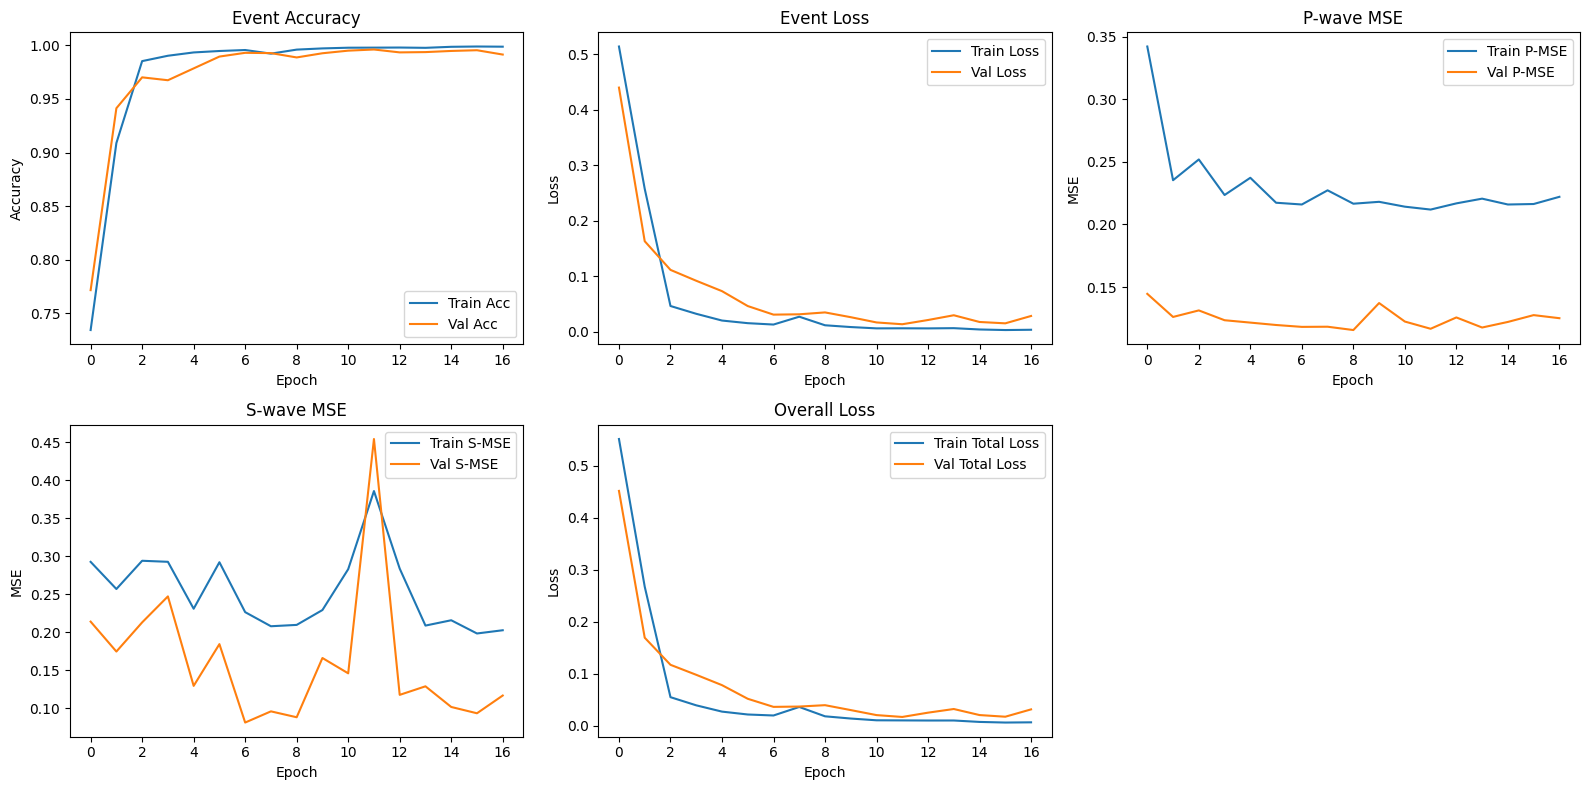

In [18]:
import matplotlib.pyplot as plt

history = history_cnn_lstm_multi_model_fixedmask.history
epochs_ran = len(history['loss'])

plt.figure(figsize=(16,8))

# 1. Event classification accuracy
plt.subplot(2,3,1)
plt.plot(history['event_output_accuracy'], label='Train Acc')
plt.plot(history['val_event_output_accuracy'], label='Val Acc')
plt.title('Event Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Event classification loss
plt.subplot(2,3,2)
plt.plot(history['event_output_loss'], label='Train Loss')
plt.plot(history['val_event_output_loss'], label='Val Loss')
plt.title('Event Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3. P-wave MSE
plt.subplot(2,3,3)
plt.plot(history['p_output_mse'], label='Train P-MSE')
plt.plot(history['val_p_output_mse'], label='Val P-MSE')
plt.title('P-wave MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# 4. S-wave MSE
plt.subplot(2,3,4)
plt.plot(history['s_output_mse'], label='Train S-MSE')
plt.plot(history['val_s_output_mse'], label='Val S-MSE')
plt.title('S-wave MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# 5. Overall model loss
plt.subplot(2,3,5)
plt.plot(history['loss'], label='Train Total Loss')
plt.plot(history['val_loss'], label='Val Total Loss')
plt.title('Overall Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
idx = np.random.randint(len(X_test))

x_sample = X_test[idx]
y_sample = {
    "event_output": y_test_multi["event_output"][idx],
    "p_output": y_test_multi["p_output"][idx],
    "s_output": y_test_multi["s_output"][idx]
}

predict_event_ps(cnn_lstm_multi_model_fixedmask, x_sample, y_sample)

Predictions : 
Event Probability: 0.9938 -> Detected: True
P Arrival Prediction: 0.1155
S Arrival Prediction: 0.2272
True Values:
Event: 1
P Arrival: 0.11666666666666667
S Arrival: 0.13666666666666666


{'event_prob': 0.9938405752182007,
 'event_detected': True,
 'p_pred': 0.11554960906505585,
 's_pred': 0.2271537035703659}

In [41]:
idx = np.random.randint(len(X_test))

x_sample = X_test[idx]
y_sample = {
    "event_output": y_test_multi["event_output"][idx],
    "p_output": y_test_multi["p_output"][idx],
    "s_output": y_test_multi["s_output"][idx]
}

predict_event_ps(cnn_lstm_multi_model_fixedmask, x_sample, y_sample)

Predictions : 
Event Probability: 0.0000 -> Detected: False
P Arrival Prediction: -0.0729
S Arrival Prediction: 0.7950
True Values:
Event: 0
P Arrival: 0.0
S Arrival: 0.0


{'event_prob': 3.137703606626019e-05,
 'event_detected': False,
 'p_pred': -0.07290440052747726,
 's_pred': 0.7949514389038086}

In [23]:
cnn_lstm_multi_model_fixedmask.save("../all_models/cnn_lstm_multi_model_fixedmask")

INFO:tensorflow:Assets written to: ../all_models/cnn_lstm_multi_model_fixedmask\assets


INFO:tensorflow:Assets written to: ../all_models/cnn_lstm_multi_model_fixedmask\assets


In [25]:
event_preds, event_true = [], []
p_preds, p_true = [], []
s_preds, s_true = [], []

for x, y in test_ds:
    preds = cnn_lstm_multi_model_fixedmask.predict(x, verbose=0)

    if isinstance(preds, dict):
        event_preds.append(preds["event_output"])
        p_preds.append(preds["p_output"])
        s_preds.append(preds["s_output"])
    else:
        event_preds.append(preds[0])
        p_preds.append(preds[1])
        s_preds.append(preds[2])
    
    event_true.append(y['event_output'])
    p_true.append(y['p_output'][:, 1])  # only arrival values
    s_true.append(y['s_output'][:, 1])

event_preds = np.concatenate(event_preds).flatten()
event_true = np.concatenate(event_true).flatten()
p_preds = np.concatenate(p_preds).flatten()
p_true = np.concatenate(p_true).flatten()
s_preds = np.concatenate(s_preds).flatten()
s_true = np.concatenate(s_true).flatten()

In [42]:
threshold = 0.5
event_pred_labels = (event_preds > threshold).astype(int)

precision = precision_score(event_true, event_pred_labels)
recall = recall_score(event_true, event_pred_labels)
f1 = f1_score(event_true, event_pred_labels)
auc = roc_auc_score(event_true, event_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Precision: 0.9988
Recall: 0.9907
F1 Score: 0.9947
AUC: 0.9998


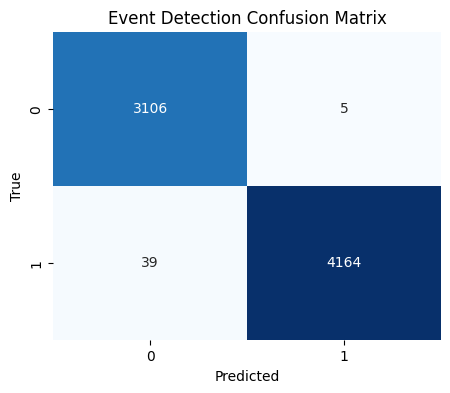

In [43]:
cm = confusion_matrix(event_true, event_pred_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Event Detection Confusion Matrix")
plt.show()

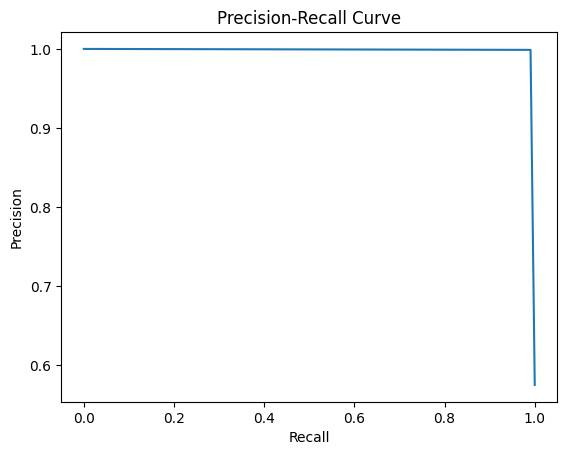

In [44]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(event_true,event_pred_labels)
plt.plot(recalls,precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [45]:
from sklearn.metrics import root_mean_squared_error
p_mae = mean_absolute_error(p_true, p_preds)
s_mae = mean_absolute_error(s_true, s_preds)
p_rmse = root_mean_squared_error(p_true, p_preds)
s_rmse = root_mean_squared_error(s_true, s_preds)

print(f"P MAE: {p_mae:.4f}, RMSE: {p_rmse:.4f}")
print(f"S MAE: {s_mae:.4f}, RMSE: {s_rmse:.4f}")

P MAE: 0.0329, RMSE: 0.0410
S MAE: 0.3548, RMSE: 0.4787


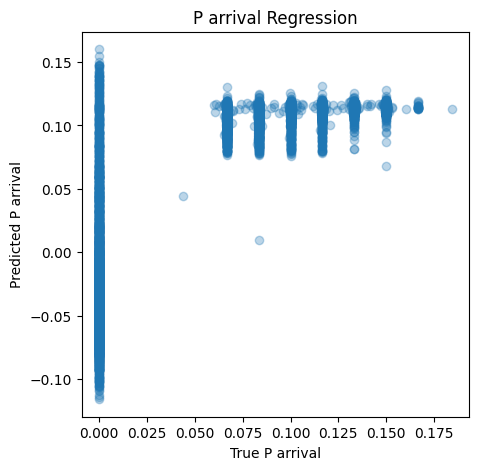

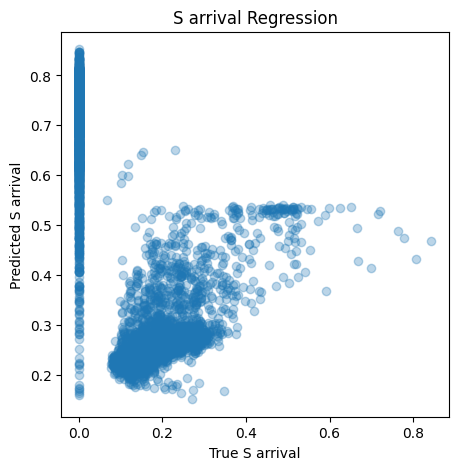

In [46]:
plt.figure(figsize=(5,5))
plt.scatter(p_true,p_preds,alpha=0.3)
plt.xlabel("True P arrival")
plt.ylabel("Predicted P arrival")
plt.title("P arrival Regression")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(s_true,s_preds,alpha=0.3)
plt.xlabel("True S arrival")
plt.ylabel("Predicted S arrival")
plt.title("S arrival Regression")
plt.show()

Grad-CAM

In [47]:
sample = X_val[11:12]

In [48]:
for layer in cnn_lstm_multi_model_fixedmask.layers:
  if 'conv' in layer.name:
    print(layer.name)

conv2d
conv2d_1
conv2d_2


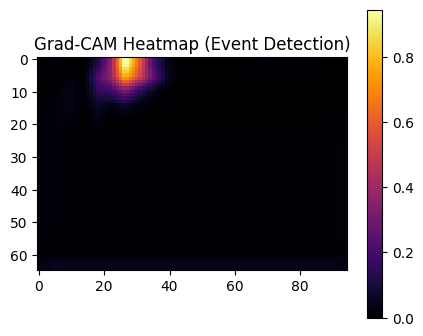

In [49]:
def get_gradcam_heatmap(model, image, last_conv_layer_name, output_name="event_output"):
    
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.get_layer(output_name).output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (65, 95))
    return heatmap.numpy().squeeze()


last_conv_layer_name = "conv2d_2"
heatmap = get_gradcam_heatmap(cnn_lstm_multi_model_fixedmask, sample, last_conv_layer_name)

plt.figure(figsize=(5, 4))
plt.imshow(heatmap, cmap="inferno")
plt.title("Grad-CAM Heatmap (Event Detection)")
plt.colorbar()
plt.show()

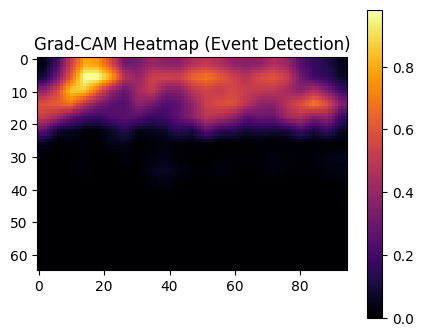

In [50]:
sample = X_test[2:3]

heatmap = get_gradcam_heatmap(cnn_lstm_multi_model_fixedmask, sample, last_conv_layer_name)

plt.figure(figsize=(5, 4))
plt.imshow(heatmap, cmap="inferno")
plt.title("Grad-CAM Heatmap (Event Detection)")
plt.colorbar()
plt.show()